In [8]:
import himalaya.scoring
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from simulation import generate_dataset

In [9]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord')
sns.set_theme(style='whitegrid')

In [10]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 3, 1 / 3]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 1000
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [11]:
alphas = np.logspace(-4, 4, 10)
cv = 10
score_func = himalaya.scoring.r2_score

In [12]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar, construction_method="random")

train joint model

In [13]:
banded_solver_params = dict(n_iter=10, alphas=alphas, progress_bar=False, warn=False, score_func=score_func,
                            n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [14]:
joint_model.fit([x[:n_samples_train] for x in Xs], Y[:n_samples_train])
joint_score = joint_model.score([x[n_samples_train:] for x in Xs], Y[n_samples_train:])
joint_score = backend.to_numpy(joint_score)

<Axes: ylabel='Count'>

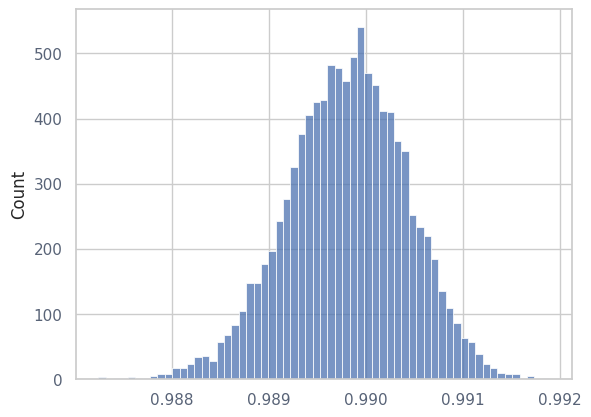

In [15]:
sns.histplot(joint_score)

train single models

In [16]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)

Fit and predict for i = 0

In [17]:
single_model.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
score_0 = single_model.score(Xs[0][n_samples_train:], Y[n_samples_train:])
score_0 = backend.to_numpy(score_0)

<Axes: ylabel='Count'>

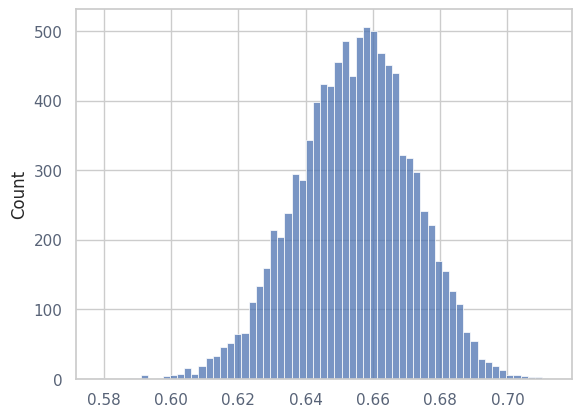

In [18]:
sns.histplot(score_0)

Fit and predict for i = 1

In [19]:
single_model.fit(Xs[1][:n_samples_train], Y[:n_samples_train])
score_1 = single_model.score(Xs[1][n_samples_train:], Y[n_samples_train:])
score_1 = backend.to_numpy(score_1)

<Axes: ylabel='Count'>

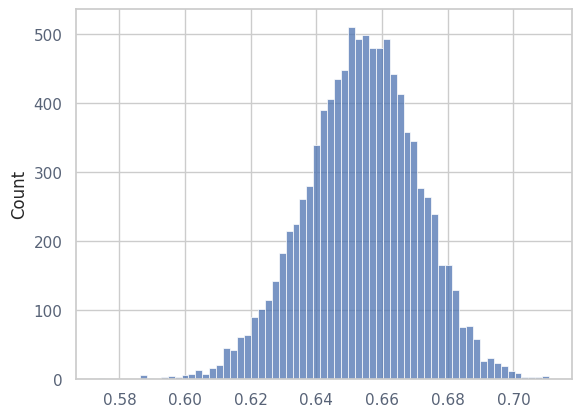

In [20]:
sns.histplot(score_1)

Calculate unique and shared variance

In [21]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [22]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [25]:
scores = pd.DataFrame(
    # create columnar data
    [joint_score, score_0, score_1, shared, x0_unique, x1_unique],
    index=[r"$X_1\cup X_2$", r"$X_1$", "$X_2$", r"$X_1\cap X_2$", r"$X_{1_{unique}}$", r"$X_{2_{unique}}$"]
)

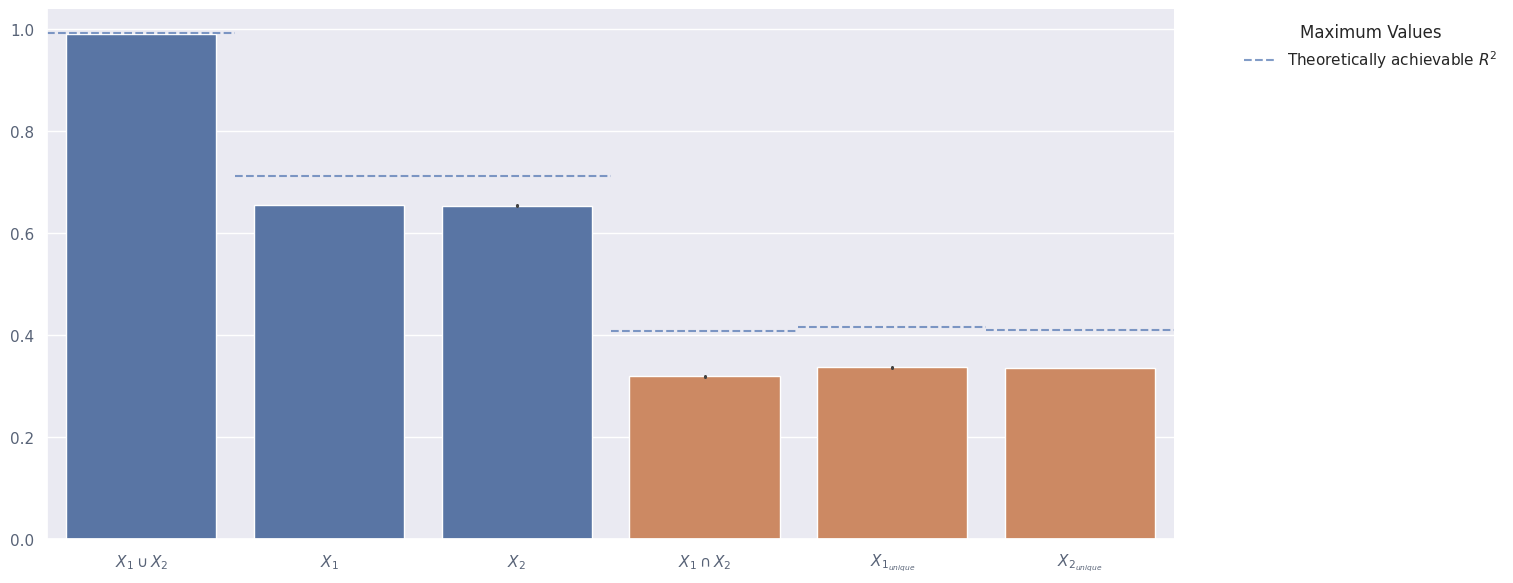

In [26]:
sns.catplot(
    data=scores.T, kind="bar", height=6, aspect=2,
    palette=["C0", "C0", "C0", "C1", "C1", "C1"]  # Define colors: one for joint/X₁/X₂, one for unique/shared
)

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(scores.index):  # iterate over rows in the DataFrame
    xmin = idx / len(scores.index)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.index)  # Calculate xmax for each bar
    plt.axhline(scores.loc[column].max(), linestyle='--', alpha=0.7,
                xmin=xmin, xmax=xmax, label=fr'Theoretically achievable $R^2$' if idx == 0 else "")

# Ensure the legend is displayed properly
plt.legend(title="Maximum Values", bbox_to_anchor=(1.05, 1), loc='upper left')